In [1]:
import os
import tensorflow as tf
from keras import models
from keras import layers

from keras import Sequential

from datetime import datetime
from PIL import Image
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import mlflow
from tensorflow.keras.layers.experimental import preprocessing


# Scientific data

In [2]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from keras.models import Model


In [3]:
K.clear_session()

In [4]:
batch_size = 64

In [5]:
mlflow.set_experiment('efficientnet_project')
mlflow.autolog()

2023/05/30 14:12:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [6]:
#Keras.sequence

In [9]:
#Check the 3!
image_size = (255, 255)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'private_dataset',
    validation_split=0.2,
    subset="training",
    label_mode = 'int',
    labels = 'inferred',
    seed=1336,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'private_dataset',
    validation_split=0.2,
    subset="validation",
    label_mode = 'int',
    labels = 'inferred',
    seed=1336,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


Found 1604 files belonging to 3 classes.
Using 1284 files for training.
Found 1604 files belonging to 3 classes.
Using 320 files for validation.


Found 1772 files belonging to 3 classes.
Using 1418 files for training.
Found 1772 files belonging to 3 classes.
Using 354 files for validation.

In [10]:
imput = (255,255,3)

In [11]:
base_model = EfficientNetB3(include_top = False ,weights='imagenet', pooling='avg')

#todo introduce a layer of data augmentation 

# Introduce a layer of data augmentation
data_augmentation = Sequential([
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
])



# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 20 layers in the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

#Capa de entradas. No se si eficientnet ya espera 225x225 o es 224 x 224. En realidad la efficient net ya tiene un parametro de input shape...
# Capa de entradas

entradas = layers.Input((255, 255, 3))

# Apply data augmentation to the input images
x = data_augmentation(entradas)


# Pass the augmented images through the base model
x = base_model(x)


# Add a dense layer
x = layers.Dense(512, activation='relu')(x)
# Add another dense layer
salidas = layers.Dense(3, activation='softmax')(x)

modelo = Model(inputs = entradas, outputs = salidas)

modelo.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
modelo.summary()




Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 255, 255, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 11,572,018
Trainable params: 2,490,371
Non-trainable params: 9,081,647
_________________________________________________________________


In [12]:
# Display the model architecture in the notebook
# plot_model(modelo, to_file='model.png', show_shapes=True)


In [13]:
folder_date = 'old_models/' +  datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
os.mkdir(folder_date)
filepath_model = folder_date + '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'


# Callbacks

In [14]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=filepath_model,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_freq="epoch",
save_best_only=True)

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='auto', verbose = 1, )

In [28]:
epochs = 30
history = modelo.fit(
    train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback]
)

2023/05/30 15:54:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a0419f1d17484a02ac7fdcdcc9abb8ee', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/30
21/21 [==============================] - 18s 800ms/step - loss: 0.1485 - accuracy: 0.9533 - val_loss: 1.0032 - val_accuracy: 0.8250
Epoch 2/30
21/21 [==============================] - 17s 768ms/step - loss: 0.0728 - accuracy: 0.9759 - val_loss: 0.4389 - val_accuracy: 0.8906
Epoch 3/30
21/21 [==============================] - 16s 767ms/step - loss: 0.0484 - accuracy: 0.9805 - val_loss: 0.5220 - val_accuracy: 0.8750
Epoch 4/30
21/21 [==============================] - 17s 781ms/step - loss: 0.0621 - accuracy: 0.9759 - val_loss: 0.6931 - val_accuracy: 0.8469
Epoch 5/30
21/21 [==============================] - 16s 762ms/step - loss: 0.0629 - accuracy: 0.9805 - val_loss: 0.7149 - val_accuracy: 0.8594
Epoch 6/30
21/21 [==============================] - 17s 778ms/step - loss: 0.0867 - accuracy: 0.9681 - val_loss: 0.6021 - val_accuracy: 0.8750
Epoch 7/30
21/21 [==============================] - 17s 783ms/step - loss: 0.0532 - accuracy: 0.9844 - val_loss: 0.5744 - val_accuracy: 0.8687

2023/05/30 16:03:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument."


In [29]:
#Guardo el modelo en la última epoch. Esto 
modelo.save(folder_date + '/modelo_entrenado.h5')


In [30]:
history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [31]:
folder_date + "/accuracy.png"

'old_models/2023_05_30-02_26_51_PM/accuracy.png'

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


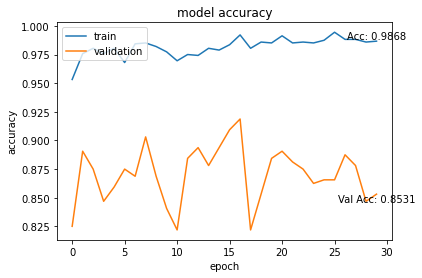

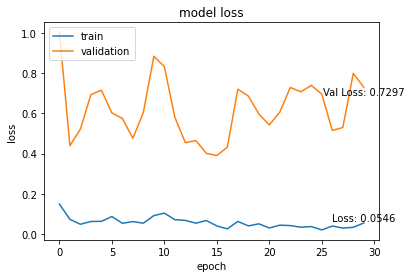

In [32]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['accuracy'])-1, history.history['accuracy'][-1], 
         f"Acc: {history.history['accuracy'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_accuracy'])-1, history.history['val_accuracy'][-1], 
         f"Val Acc: {history.history['val_accuracy'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/accuracy.png")
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['loss'])-1, history.history['loss'][-1], 
         f"Loss: {history.history['loss'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_loss'])-1, history.history['val_loss'][-1], 
         f"Val Loss: {history.history['val_loss'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/loss.png")
plt.show()





Preguntas, cómo puedo gestionar datos que vienen de dos distribuciones distintas?



# This is a section to evaluate the model on te test data

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Precision: 0.8686000379548767
Recall: 0.8461538461538461
Accur

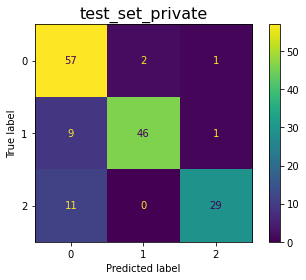

In [35]:
# Load the test images from the folder 'test_images'
predicted_labels= []
true_labels = []

directory = "test_set_private"

for filename in os.listdir(directory):

    # Load the image and add it to the list of test images
    f = os.path.join(directory, filename)
    imagen = tf.keras.preprocessing.image.load_img(f, target_size=(255,255))
    x = tf.keras.preprocessing.image.img_to_array(imagen)    
    x = np.expand_dims(x, axis=0)



    prediction = modelo.predict(x)    

    predicted_class = np.argmax(prediction)

    #True labels are calculated based on name. It is a very weak way of doing it. Look for a better one or rename the files

    if 'aca' in filename:
        true_labels.append(0)
    elif 'scc' in filename:
        true_labels.append(2)
    elif 'nor' in filename:
        true_labels.append(1)
   
    

    predicted_labels.append(predicted_class)

print(predicted_labels)
print(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)


# Calculate precision, recall, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)



disp.plot()
plt.title(directory,  fontdict={'fontsize': 16})  # Set the new title for the plot
plt.show()



#Predice mal en las muestras de Henar. Veremos con el nuevo dataset, pero quizá haya que hacer un training con peso Opciones:

Undersample the larger distribution: randomly remove examples from the larger distribution until it matches the size of the smaller one.

Oversample the smaller distribution: randomly duplicate examples from the smaller distribution until it matches the size of the larger one.

Data augmentation: generate new examples from the smaller distribution using techniques like rotation, flipping, or zooming.

Use class weights: adjust the loss function of your CNN to assign higher weights to the smaller distribution so that it receives more emphasis during training.

Fine-tuning: you could use a pre-trained model to initialize the weights and only fine-tune the last few layers to fit the imbalanced data.